# Explore SVD based word embedding

This notebook explores word embeddings that are based on SVD of a possibly transformed word-context matrix. Starting with the raw matrix `counts`

- possilby transform `counts` (e.g. log data, do PPMI transform, normalize rows)
- compute SVD of new matrix
- explore word embeddings e.g. scores plots, word similarity
- explore loadings

The material in this notebook is covered in chapters 15/16 of SLP3
- https://web.stanford.edu/~jurafsky/slp3/15.pdf
- https://web.stanford.edu/~jurafsky/slp3/16.pdf


## data

The github repo comes with a small data set pre computed (from a random sample of 1000 court cases). You can download larger data files from https://drive.google.com/open?id=0B40b05f-8LWtVGsybWw4OTVyV00 then place them in the data/ folder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

from scipy.sparse.linalg import svds, norm
from scipy.sparse import diags, csr_matrix, dok_matrix

# import local code files
import sys, os
sys.path.append(os.getcwd() + '/code/')

# working with word embeddings
from save import load_vocabulary, load_matrix
from ppmi import calc_ppmi
from word_similarity import similarity, closest
from transform_counts import remove_zero_count_words

# exploring/visualizing scores/loadings
from scores_viz import scores_plot, filter_scores
from explore_loadings import top_loading_components, top_loading_words, top_loading_words_df

# only import this if you have plot.ly installed
# from viz_plotly import interactive_scores_plot

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
w2i, i2w = load_vocabulary('data/vocab_small_ex.txt')
co_counts = load_matrix('data/co_counts_small_ex')
word_counts = np.load('data/word_counts_small_ex.npy')

# uncomment this code if you have the larger data file
# w2i, i2w = load_vocabulary('data/vocab_10000.txt')
# co_counts = load_matrix('data/co_counts_10000')
# word_counts = np.load('data/word_counts_10000.npy')

In [3]:
co_counts

<43513x43513 sparse matrix of type '<class 'numpy.float64'>'
	with 13837026 stored elements in Compressed Sparse Row format>

# transform counts


In [4]:
# normalized row by row norms
co_counts_normed = diags(1.0/norm(co_counts, axis=1)) * co_counts 

In [5]:
co_counts_log = co_counts
co_counts_log.data = np.log(1 + co_counts.data)

In [6]:
ppmi = calc_ppmi(co_counts)

# SVD of counts matrix

If $X \in \mathbb{R}^{n \times d}$ is a data matrix with the n observations on rows then the rank K SVD is given by
$$X \approx U D V^T$$
where $U \in \mathbb{R}^{n \times K}$ is the matrix of normalized scores and  $V \in \mathbb{R}^{d \times K}$ is the matrix of loadings.

If X is a word-context matrix then U (or UD) gives a word embedding.

In [7]:
%%time
k = 10

normed_scores, sing_vals, loadings = svds(co_counts_normed, k)

loadings = loadings.T
un_normed_scores = normed_scores * sing_vals

CPU times: user 12.9 s, sys: 184 ms, total: 13.1 s
Wall time: 3.33 s


In [8]:
embedding = un_normed_scores

# Explore word embedding (scores)

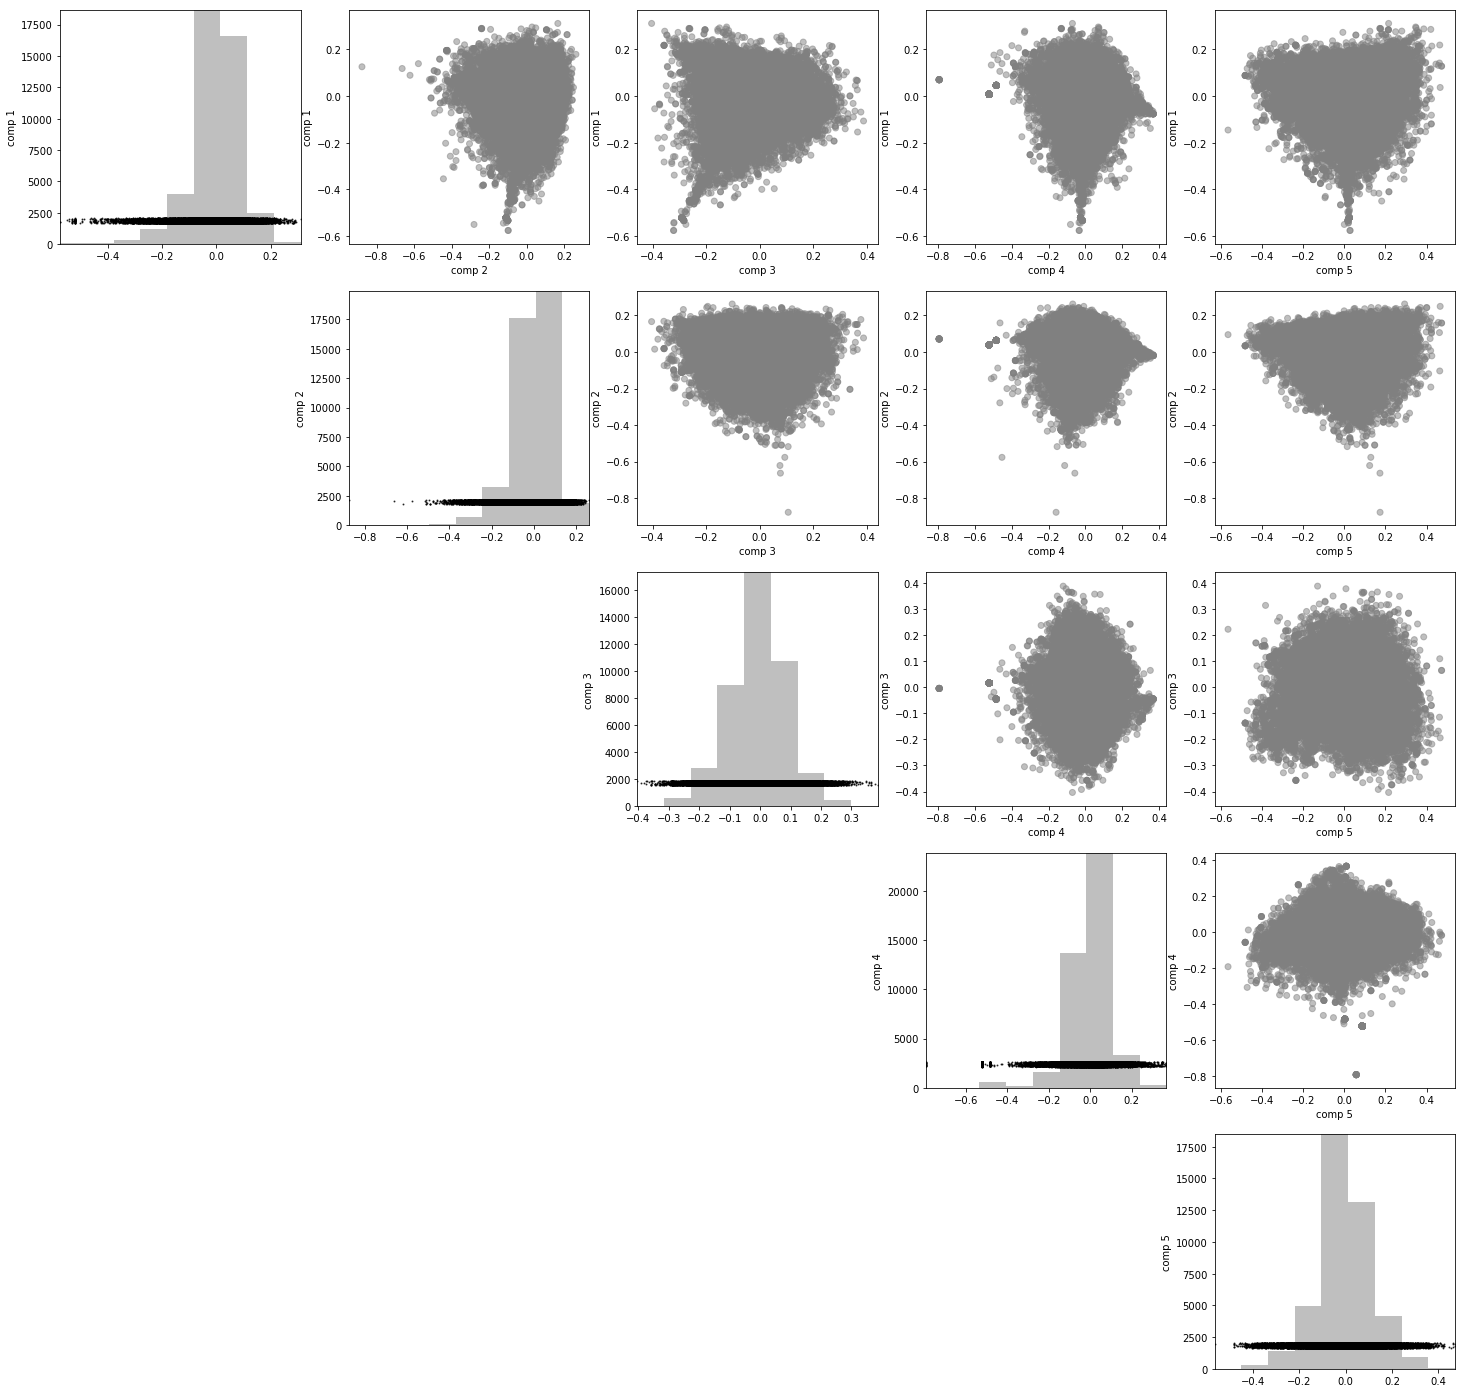

In [9]:
scores_plot(embedding,
            start=1,
            n_comp=5,
            title='',
            comp_names=None)

In [10]:
# this won't run if you don't have plot.ly already installed
# from viz_plotly import interactive_scores_plot
# interactive_scores_plot(scores,comp1=1, comp2=3, labels=i2w)

# simlarity

In [11]:
word1 = 'lawyer'
word2 = 'lawyers'

word1 = i2w[0]
word2 = i2w[1]

similarity(word1, word2, embedding, w2i, sim='angle')

51.495201159034529

In [12]:
word = 'lawyer'

word = i2w[0]
closest(word, embedding, w2i, N=10)

['147a',
 'holidays',
 'carlson',
 'locate',
 'junction',
 'quin',
 'importance',
 'flint',
 'occurred—that',
 'eisenstadt']

# explore loadings

In [13]:
top_loading_df = top_loading_words_df(loadings, i2w, n=30)

top_loading_df

,1,2,3,4,5,6,7,8,9,10
1,at,in,a,states,and,and,of,v,to,the
2,that,a,to,united,a,the,the,us,by,of
3,a,to,at,of,that,a,v,states,line,to
4,s,at,by,court,by,for,states,the,straight,and
5,for,by,for,supreme,to,in,united,united,the,in
6,”,that,and,and,the,states,supreme,of,of,a
7,“,us,or,in,in,court,court,co,at,that
8,id,and,the,v,is,united,us,see,arc,by
9,or,is,s,that,or,or,that,court,centered,for
10,see,the,be,us,for,supreme,in,at,court,is


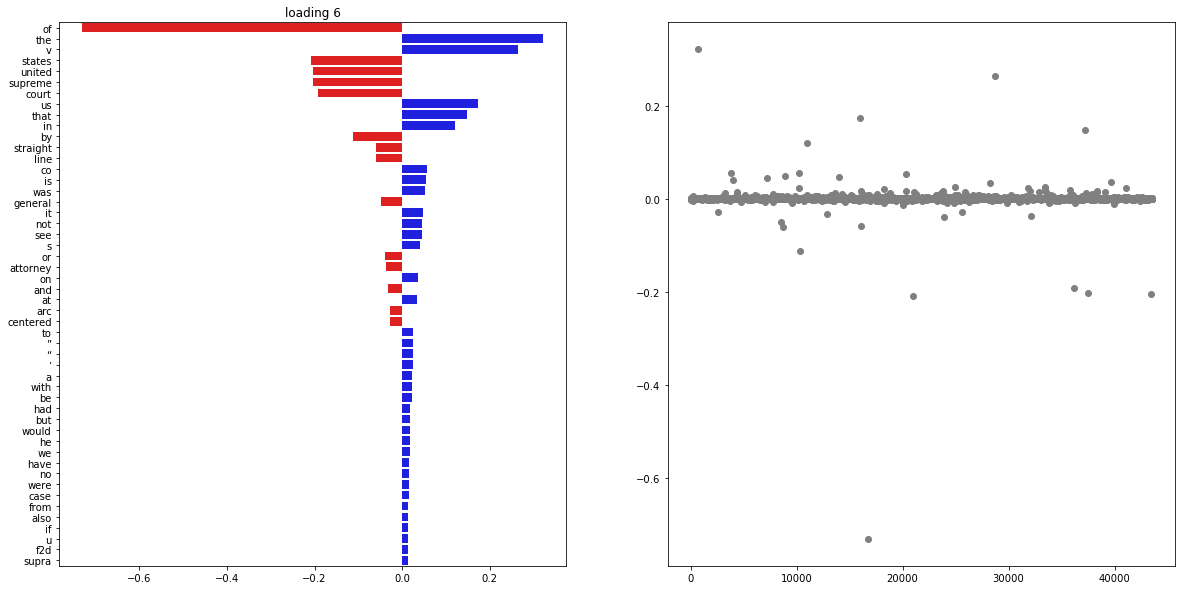

In [14]:
comp_numer = 6  # which loading
n = 50 # how many components to show

plt.figure(figsize=[20, 10])

plt.subplot(1,2,1)
top_loading_components(loadings[:, comp_numer], i2w, n, comp_numer)


plt.subplot(1,2,2)
plt.scatter(range(loadings.shape[0]), loadings[:, comp_numer], color='grey')